# Visualizing Google Forms Data with Seaborn

This is the second part of an article from [Practical Business Python](htp://pbpython.com) describing how to retrieve and analyze data from a Google Form.

Please review [part 1](http://pbpython.com/pandas-google-forms-part1.html) for the details of how to set up authentication and get the data into the pandaqs dataframe.

The full article corresponding to this notebook is [here](http://pbpython.com/pandas-google-forms-part2.html)

## Setup

Bring in our standard imports as well as the authentication libraries we will need to get access to our form.

In [1]:
import gspread
from oauth2client.client import SignedJwtAssertionCredentials
import pandas as pd
import json

Import Ipython display as well as graphing libraries. For this article, we will be using [seaborn](http://stanford.edu/~mwaskom/software/seaborn/index.html).

In [2]:
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Setup authentication process to pull in the survey data stored in the Google Sheet.

In [3]:
SCOPE = ["https://spreadsheets.google.com/feeds"]
SECRETS_FILE = "Pbpython-key.json"
SPREADSHEET = "PBPython User Survey (Responses)"
# Based on docs here - http://gspread.readthedocs.org/en/latest/oauth2.html
# Load in the secret JSON key (must be a service account)
json_key = json.load(open(SECRETS_FILE))
# Authenticate using the signed key
credentials = SignedJwtAssertionCredentials(json_key['client_email'],
                                            json_key['private_key'], SCOPE)

Now open up the file and read all data in a DataFrame

In [4]:
gc = gspread.authorize(credentials)
# Open up the workbook based on the spreadsheet name
workbook = gc.open(SPREADSHEET)
# Get the first sheet
sheet = workbook.sheet1
# Extract all data into a dataframe
results = pd.DataFrame(sheet.get_all_records())
results.head()

,How frequently do you use the following tools? [Javascript],How frequently do you use the following tools? [Python],How frequently do you use the following tools? [R],How frequently do you use the following tools? [Ruby],How frequently do you use the following tools? [SQL],How frequently do you use the following tools? [VBA],How useful is the content on practical business python?,How would you like to be notified about new articles on this site?,Timestamp,What suggestions do you have for future content?,What version of python would you like to see used for the examples on the site?,Which OS do you use most frequently?,Which python distribution do you primarily use?
0,Once a month,A couple times a week,Infrequently,Never,Once a month,Never,3,RSS,6/9/2015 23:22:43,,2.7,Mac,Included with OS - Mac
1,Once a month,Daily,A couple times a week,Never,Infrequently,Infrequently,3,Reddit,6/10/2015 1:19:08,,2.7,Windows,Anaconda
2,Infrequently,Daily,Once a month,Never,Daily,Never,2,Planet Python,6/10/2015 1:40:29,,3.4+,Windows,Official python.org binaries
3,Never,Daily,Once a month,Never,A couple times a week,Once a month,3,Planet Python,6/10/2015 1:55:46,,2.7,Mac,Official python.org binaries
4,Once a month,Daily,Infrequently,Infrequently,Once a month,Never,3,Leave me alone - I will find it if I need it,6/10/2015 4:10:17,,I don't care,Mac,Anaconda


We need to do some cleanup to make the data easier to analyze.

In [5]:
# Do some minor cleanups on the data
# Rename the columns to make it easier to manipulate
# The data comes in through a dictionary so we can not assume order stays the
# same so must name each column
column_names = {'Timestamp': 'timestamp',
                'What version of python would you like to see used for the examples on the site?': 'version',
                'How useful is the content on practical business python?': 'useful',
                'What suggestions do you have for future content?': 'suggestions',
                'How frequently do you use the following tools? [Python]': 'freq-py',
                'How frequently do you use the following tools? [SQL]': 'freq-sql',
                'How frequently do you use the following tools? [R]': 'freq-r',
                'How frequently do you use the following tools? [Javascript]': 'freq-js',
                'How frequently do you use the following tools? [VBA]': 'freq-vba',
                'How frequently do you use the following tools? [Ruby]': 'freq-ruby',
                'Which OS do you use most frequently?': 'os',
                'Which python distribution do you primarily use?': 'distro',
                'How would you like to be notified about new articles on this site?': 'notify'
                }
results.rename(columns=column_names, inplace=True)
results.timestamp = pd.to_datetime(results.timestamp)
results.head()

,freq-js,freq-py,freq-r,freq-ruby,freq-sql,freq-vba,useful,notify,timestamp,suggestions,version,os,distro
0,Once a month,A couple times a week,Infrequently,Never,Once a month,Never,3,RSS,2015-06-09 23:22:43,,2.7,Mac,Included with OS - Mac
1,Once a month,Daily,A couple times a week,Never,Infrequently,Infrequently,3,Reddit,2015-06-10 01:19:08,,2.7,Windows,Anaconda
2,Infrequently,Daily,Once a month,Never,Daily,Never,2,Planet Python,2015-06-10 01:40:29,,3.4+,Windows,Official python.org binaries
3,Never,Daily,Once a month,Never,A couple times a week,Once a month,3,Planet Python,2015-06-10 01:55:46,,2.7,Mac,Official python.org binaries
4,Once a month,Daily,Infrequently,Infrequently,Once a month,Never,3,Leave me alone - I will find it if I need it,2015-06-10 04:10:17,,I don't care,Mac,Anaconda


There are a small number of free form comments. Let's strip those out and remove them from the results.

In [6]:
suggestions = results[results.suggestions.str.len() > 0]["suggestions"]

Since there are only a small number of comments, just print them out.
However, if we had more comments and wanted to do more analysis we certainly good.

In [7]:
for index, row in suggestions.iteritems():
    display(row)

'A bit more coverage on how to make presentations - which in a lot of corporations just means powerpoint slides with python, from a business analyst perspective, of course'

'Add some other authors to the website which can publish equally relevant content. Would  be nice to see more frequent updates if possible, keep up the good work!'

'How to produce graphics using Python, Google Forms.'

'Awesome site - keep up the good work'

'Great job on the site.  Nice to see someone writing about actual Python use cases. So much writing is done elsewhere about software development without the connection to actual business work.'

Drop the suggestions. We won't use them any more.

In [8]:
results.drop("suggestions", axis=1, inplace=True)
results.head()

,freq-js,freq-py,freq-r,freq-ruby,freq-sql,freq-vba,useful,notify,timestamp,version,os,distro
0,Once a month,A couple times a week,Infrequently,Never,Once a month,Never,3,RSS,2015-06-09 23:22:43,2.7,Mac,Included with OS - Mac
1,Once a month,Daily,A couple times a week,Never,Infrequently,Infrequently,3,Reddit,2015-06-10 01:19:08,2.7,Windows,Anaconda
2,Infrequently,Daily,Once a month,Never,Daily,Never,2,Planet Python,2015-06-10 01:40:29,3.4+,Windows,Official python.org binaries
3,Never,Daily,Once a month,Never,A couple times a week,Once a month,3,Planet Python,2015-06-10 01:55:46,2.7,Mac,Official python.org binaries
4,Once a month,Daily,Infrequently,Infrequently,Once a month,Never,3,Leave me alone - I will find it if I need it,2015-06-10 04:10:17,I don't care,Mac,Anaconda


## Explore the data

For Numeric columns, start with describe to see what we have

In [9]:
results.describe()

,useful
count,55.000000
mean,2.072727
std,0.790090
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,3.000000


Because we only have 1, 2, 3 as options the numeric results aren't telling us that much. I am going to convert the number to more useful descriptions.

In [10]:
results['useful'] = results['useful'].map({1: '1-low', 2: '2-medium', 3: '3-high'})
results.head()

,freq-js,freq-py,freq-r,freq-ruby,freq-sql,freq-vba,useful,notify,timestamp,version,os,distro
0,Once a month,A couple times a week,Infrequently,Never,Once a month,Never,3-high,RSS,2015-06-09 23:22:43,2.7,Mac,Included with OS - Mac
1,Once a month,Daily,A couple times a week,Never,Infrequently,Infrequently,3-high,Reddit,2015-06-10 01:19:08,2.7,Windows,Anaconda
2,Infrequently,Daily,Once a month,Never,Daily,Never,2-medium,Planet Python,2015-06-10 01:40:29,3.4+,Windows,Official python.org binaries
3,Never,Daily,Once a month,Never,A couple times a week,Once a month,3-high,Planet Python,2015-06-10 01:55:46,2.7,Mac,Official python.org binaries
4,Once a month,Daily,Infrequently,Infrequently,Once a month,Never,3-high,Leave me alone - I will find it if I need it,2015-06-10 04:10:17,I don't care,Mac,Anaconda


Value counts give us an easy distribution view into the raw numbers

In [11]:
results["version"].value_counts()

2.7             23
3.4+            18
I don't care    14
dtype: int64

Use normalize to see it by percentage.

In [12]:
results.os.value_counts(normalize=True)

Windows    0.381818
Linux      0.363636
Mac        0.254545
dtype: float64

While the numbers are useful, wouldn't it be nicer to visually show the results?

Seaborn's [factorplot](http://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.factorplot.html) is helpful for showing this kind of categorical data.

Because factorplot is so powerful, I'll build up step by step to show how it can be used for complex data analysis.

First, look at number of users by OS.

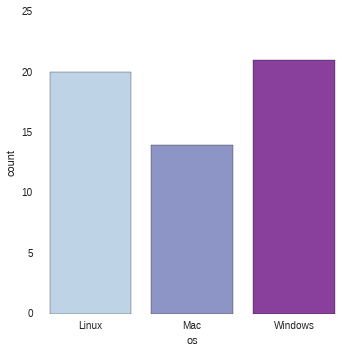

In [13]:
sns.factorplot("os", data=results, palette="BuPu")

It is easy to order the results using x_order

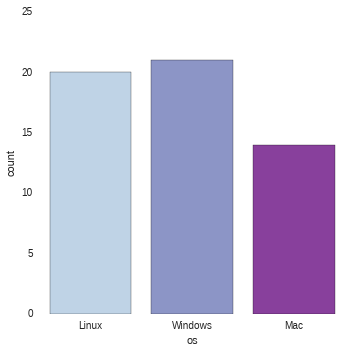

In [14]:
sns.factorplot("os", x_order=["Linux", "Windows", "Mac"], data=results, palette="BuPu")

Do a similar plot on python version

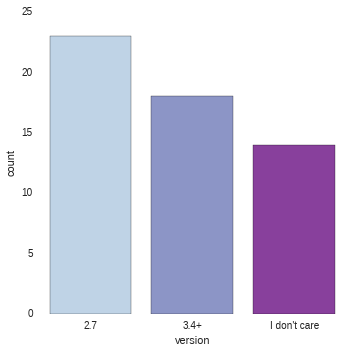

In [15]:
sns.factorplot("version", data=results, palette="BuPu")

This is useful but wouldn't it be better to compare with OS and preferred python version? This is where factorplot starts to show more versatility. The key component is to use hue to automatically slice the data by python version (in this case).

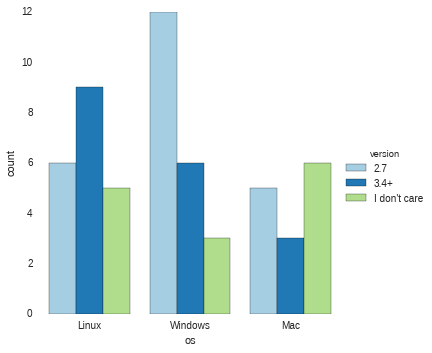

In [16]:
sns.factorplot("os", hue="version", x_order=["Linux", "Windows", "Mac"], data=results, palette="Paired")

Because seaborn knows how to work with dataframes, we just need to pass in the column names for the various arguments and it will do the analysis and presentation.

How about if we try to see if there is any relationship between how useful the site is and OS/Python choice? We can add the useful column into the plot using col.

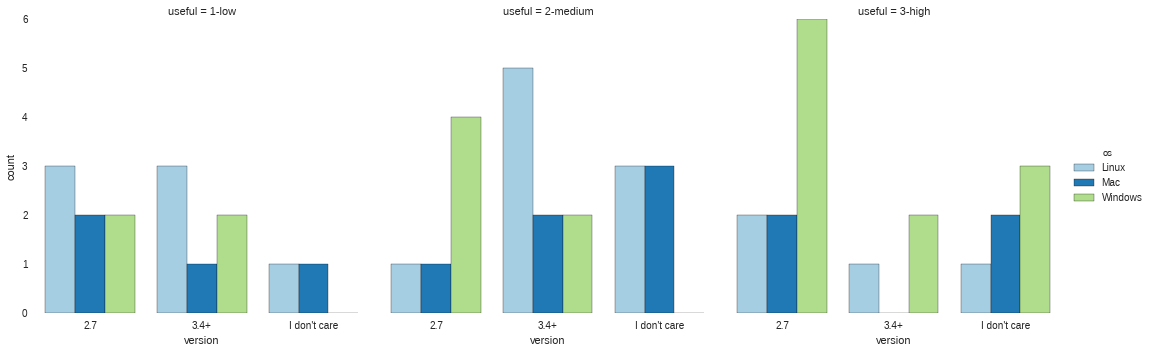

In [17]:
sns.factorplot("version", hue="os", data=results, col="useful", palette="Paired")

If we can add a column, we can also add a row and seaborn takes care of the rest.

In looking at the data, we have two different versions of winpython so clean that up first.

In [18]:
results['distro'] = results['distro'].str.replace('WinPython', 'winpython')

In [19]:
results.head()

,freq-js,freq-py,freq-r,freq-ruby,freq-sql,freq-vba,useful,notify,timestamp,version,os,distro
0,Once a month,A couple times a week,Infrequently,Never,Once a month,Never,3-high,RSS,2015-06-09 23:22:43,2.7,Mac,Included with OS - Mac
1,Once a month,Daily,A couple times a week,Never,Infrequently,Infrequently,3-high,Reddit,2015-06-10 01:19:08,2.7,Windows,Anaconda
2,Infrequently,Daily,Once a month,Never,Daily,Never,2-medium,Planet Python,2015-06-10 01:40:29,3.4+,Windows,Official python.org binaries
3,Never,Daily,Once a month,Never,A couple times a week,Once a month,3-high,Planet Python,2015-06-10 01:55:46,2.7,Mac,Official python.org binaries
4,Once a month,Daily,Infrequently,Infrequently,Once a month,Never,3-high,Leave me alone - I will find it if I need it,2015-06-10 04:10:17,I don't care,Mac,Anaconda


We can also look at the distros. Since there is some overlap with the distros and os, let's only look at a subset of distros. For instance, someone using winpython is not going to be using it on a Mac.

In [20]:
results['distro'].value_counts()

Anaconda                        22
Official python.org binaries    13
Included with OS - Linux        11
Included with OS - Mac           4
winpython                        3
Docker Python image              1
3rd party packager               1
dtype: int64

The most meaningful data would be looking at the Anaconda and Official python.org binaries. Let's filter all of our data only on these two values.

In [21]:
results_distro = results[results["distro"].isin(["Anaconda", "Official python.org binaries"])]
results_distro.head()

,freq-js,freq-py,freq-r,freq-ruby,freq-sql,freq-vba,useful,notify,timestamp,version,os,distro
1,Once a month,Daily,A couple times a week,Never,Infrequently,Infrequently,3-high,Reddit,2015-06-10 01:19:08,2.7,Windows,Anaconda
2,Infrequently,Daily,Once a month,Never,Daily,Never,2-medium,Planet Python,2015-06-10 01:40:29,3.4+,Windows,Official python.org binaries
3,Never,Daily,Once a month,Never,A couple times a week,Once a month,3-high,Planet Python,2015-06-10 01:55:46,2.7,Mac,Official python.org binaries
4,Once a month,Daily,Infrequently,Infrequently,Once a month,Never,3-high,Leave me alone - I will find it if I need it,2015-06-10 04:10:17,I don't care,Mac,Anaconda
5,Once a month,Daily,,,A couple times a week,,1-low,Feedly,2015-06-10 04:53:49,2.7,Windows,Official python.org binaries


Now do our factorplot with multiple columns and rows using row and col.

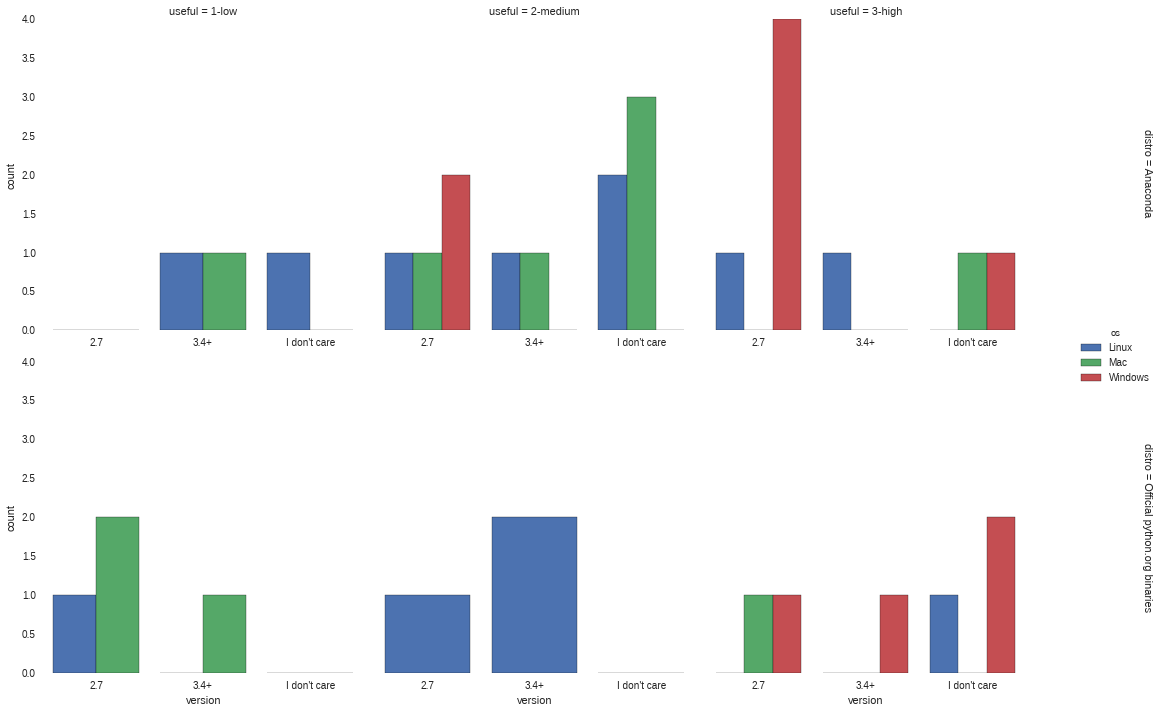

In [22]:
sns.factorplot("version", hue="os", data=results_distro, col="useful", row="distro", margin_titles=True, sharex=False)

## Responses over time

We know that we have 55 results now. It would be interesting to see how those results came in over time. Using this method, we can very simply look at this by any time period we want.

The seaborn's [timeseries](http://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.tsplot.html) supports this type of analysis and much more.

For ease of calculating responses over time, add a count colum for each response.

In [23]:
results["count"] = 1
results.head()

,freq-js,freq-py,freq-r,freq-ruby,freq-sql,freq-vba,useful,notify,timestamp,version,os,distro,count
0,Once a month,A couple times a week,Infrequently,Never,Once a month,Never,3-high,RSS,2015-06-09 23:22:43,2.7,Mac,Included with OS - Mac,1
1,Once a month,Daily,A couple times a week,Never,Infrequently,Infrequently,3-high,Reddit,2015-06-10 01:19:08,2.7,Windows,Anaconda,1
2,Infrequently,Daily,Once a month,Never,Daily,Never,2-medium,Planet Python,2015-06-10 01:40:29,3.4+,Windows,Official python.org binaries,1
3,Never,Daily,Once a month,Never,A couple times a week,Once a month,3-high,Planet Python,2015-06-10 01:55:46,2.7,Mac,Official python.org binaries,1
4,Once a month,Daily,Infrequently,Infrequently,Once a month,Never,3-high,Leave me alone - I will find it if I need it,2015-06-10 04:10:17,I don't care,Mac,Anaconda,1


To get totals over time, set our index to the timestamp

In [24]:
total_results = results.set_index('timestamp')
total_results.head()

,freq-js,freq-py,freq-r,freq-ruby,freq-sql,freq-vba,useful,notify,version,os,distro,count
timestamp,,,,,,,,,,,,
2015-06-09 23:22:43,Once a month,A couple times a week,Infrequently,Never,Once a month,Never,3-high,RSS,2.7,Mac,Included with OS - Mac,1
2015-06-10 01:19:08,Once a month,Daily,A couple times a week,Never,Infrequently,Infrequently,3-high,Reddit,2.7,Windows,Anaconda,1
2015-06-10 01:40:29,Infrequently,Daily,Once a month,Never,Daily,Never,2-medium,Planet Python,3.4+,Windows,Official python.org binaries,1
2015-06-10 01:55:46,Never,Daily,Once a month,Never,A couple times a week,Once a month,3-high,Planet Python,2.7,Mac,Official python.org binaries,1
2015-06-10 04:10:17,Once a month,Daily,Infrequently,Infrequently,Once a month,Never,3-high,Leave me alone - I will find it if I need it,I don't care,Mac,Anaconda,1


Use pandas TimeGrouper to summarize the data by day and do a cumulative sum. We could easily do this for any time period too.

In [25]:
running_results = total_results.groupby(pd.TimeGrouper('D'))["count"].count().cumsum()
running_results

timestamp
2015-06-09     1
2015-06-10    17
2015-06-11    22
2015-06-12    26
2015-06-13    27
2015-06-14    30
2015-06-15    33
2015-06-16    34
2015-06-17    35
2015-06-18    41
2015-06-19    46
2015-06-20    49
2015-06-21    49
2015-06-22    50
2015-06-23    51
2015-06-24    52
2015-06-25    52
2015-06-26    53
2015-06-27    53
2015-06-28    53
2015-06-29    53
2015-06-30    53
2015-07-01    53
2015-07-02    55
Freq: D, Name: count, dtype: int64

To label the x-axis we need to define our time range

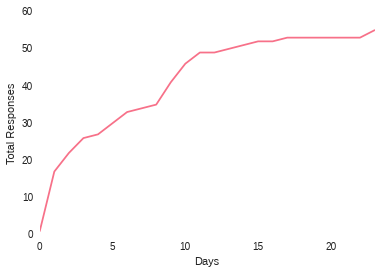

In [26]:
step = pd.Series(range(0,len(running_results)), name="Days")
sns.tsplot(running_results, value="Total Responses", time=step, color="husl")

## Heatmaps and Clustermaps

The final section of data to analyze is the frequency with which readers are using different technology. I am going to use a [heatmap](http://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.heatmap.html#seaborn.heatmap) to look for any interesting insights.

Let's look at the data again.

In [27]:
results.head()

,freq-js,freq-py,freq-r,freq-ruby,freq-sql,freq-vba,useful,notify,timestamp,version,os,distro,count
0,Once a month,A couple times a week,Infrequently,Never,Once a month,Never,3-high,RSS,2015-06-09 23:22:43,2.7,Mac,Included with OS - Mac,1
1,Once a month,Daily,A couple times a week,Never,Infrequently,Infrequently,3-high,Reddit,2015-06-10 01:19:08,2.7,Windows,Anaconda,1
2,Infrequently,Daily,Once a month,Never,Daily,Never,2-medium,Planet Python,2015-06-10 01:40:29,3.4+,Windows,Official python.org binaries,1
3,Never,Daily,Once a month,Never,A couple times a week,Once a month,3-high,Planet Python,2015-06-10 01:55:46,2.7,Mac,Official python.org binaries,1
4,Once a month,Daily,Infrequently,Infrequently,Once a month,Never,3-high,Leave me alone - I will find it if I need it,2015-06-10 04:10:17,I don't care,Mac,Anaconda,1


In [28]:
results["freq-py"].value_counts()

Daily                    36
A couple times a week    15
Once a month              3
                          1
dtype: int64

What we need to do is construct a single DataFrame with all the value_counts for the specific technology.
First we will create a list containing each value count.

In [29]:
all_counts = []
for tech in ["freq-py", "freq-sql", "freq-r", "freq-ruby", "freq-js", "freq-vba"]:
    all_counts.append(results[tech].value_counts())
display(all_counts)

[Daily                    36
 A couple times a week    15
 Once a month              3
                           1
 dtype: int64, A couple times a week    18
 Daily                    13
 Infrequently             13
 Never                     5
 Once a month              4
                           2
 dtype: int64, Never                    24
 Infrequently             16
 Once a month              5
 Daily                     4
                           3
 A couple times a week     3
 dtype: int64, Never           45
 Infrequently     7
                  2
 Once a month     1
 dtype: int64, Never                    18
 Once a month             16
 Infrequently             12
 Daily                     5
 A couple times a week     3
                           1
 dtype: int64, Never           37
 Infrequently     7
 Once a month     6
 Daily            3
                  2
 dtype: int64]

Now, concat the lists along axis=1.

Fill in any nan values with 0 too.

In [30]:
tech_usage = pd.concat(all_counts, keys=["Python", "SQL", "R", "Ruby", "javascript", "VBA"], axis=1)
tech_usage = tech_usage.fillna(0)
tech_usage

,Python,SQL,R,Ruby,javascript,VBA
,1,2,3,2,1,2
A couple times a week,15,18,3,0,3,0
Daily,36,13,4,0,5,3
Infrequently,0,13,16,7,12,7
Never,0,5,24,45,18,37
Once a month,3,4,5,1,16,6


We have a nice table but there are a few problems.

First, we have one column with blank values that we don't want.

Secondly, we would like to order from Daily -> Never. Use reindex to accomplish both tasks.

In [31]:
tech_usage = tech_usage.reindex(["Daily", "A couple times a week", "Once a month", "Infrequently", "Never"])
tech_usage

,Python,SQL,R,Ruby,javascript,VBA
Daily,36,13,4,0,5,3
A couple times a week,15,18,3,0,3,0
Once a month,3,4,5,1,16,6
Infrequently,0,13,16,7,12,7
Never,0,5,24,45,18,37


Now that the data is in the correct table format, we can create a heatmap.

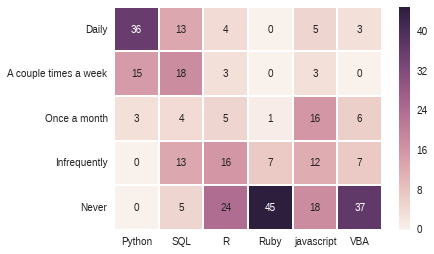

In [32]:
sns.heatmap(tech_usage, annot=True)

So, what does this tell us?

Not surprisingly, most people use python very frequently.

Additionally, it looks like very few survey takers are using Ruby or VBA.

A variation of the heatmap is the [clustermap](http://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.clustermap.html#seaborn.clustermap). The main feature it does is that it tries to reorganize the data to more easily see relationships/clusters.

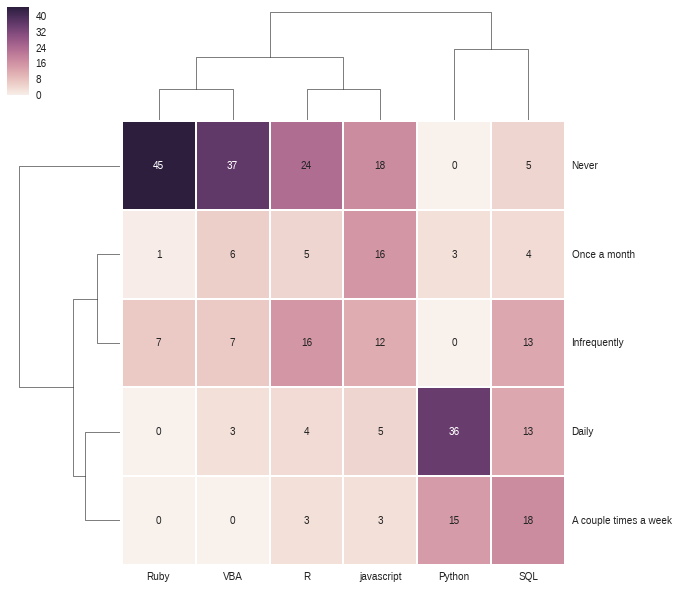

In [33]:
sns.clustermap(tech_usage, annot=True)

At first glance, it may seem to be a repeat but you'll notice that the order of the axes are different.

For instance, python and SQL are clusterd in the lower right with higher usage and Ruby and VBA have a cluster in the upper left with lower usage.